In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

mkdir: data/: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1568k      0  0:00:07  0:00:07 --:--:-- 3131k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/an

In [2]:
data_dir = "data/animais"

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Imagens Originais


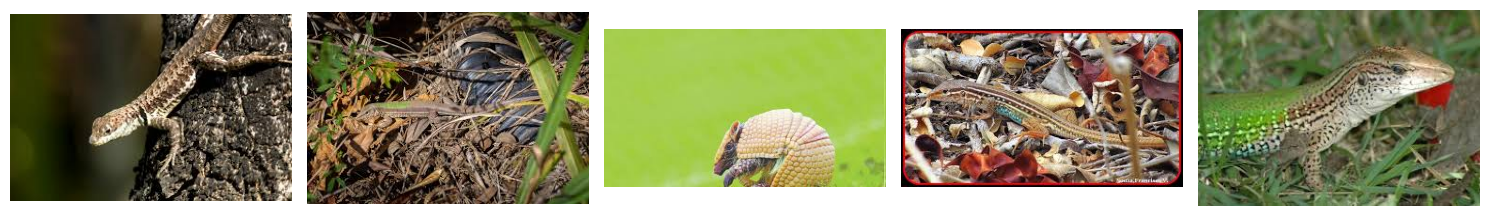

Após RandomResizedCrop


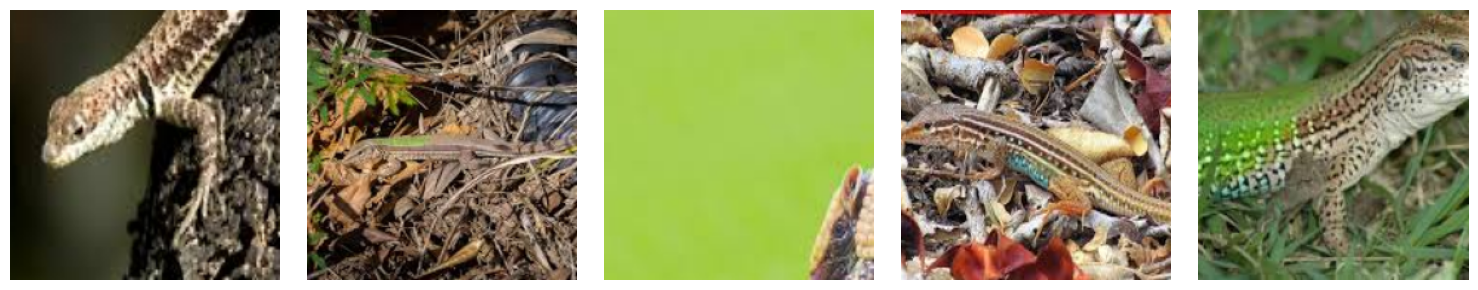

Após RandomHorizontalFlip


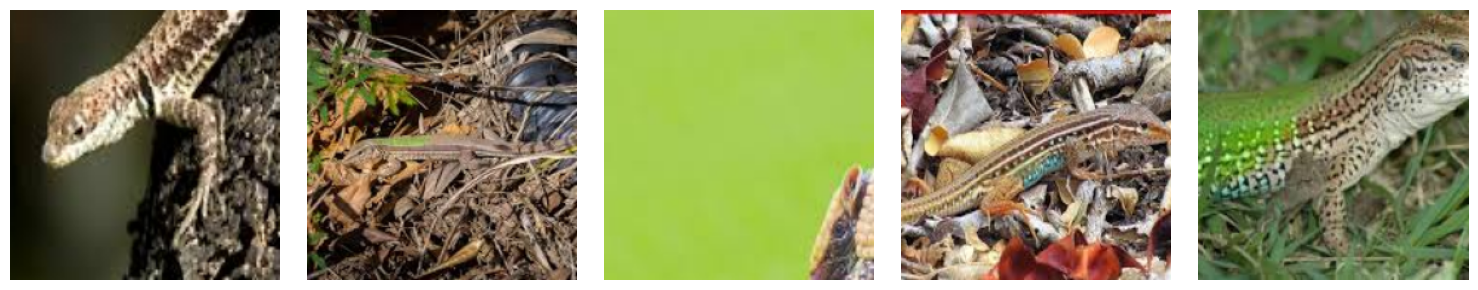

Após RandomRotation


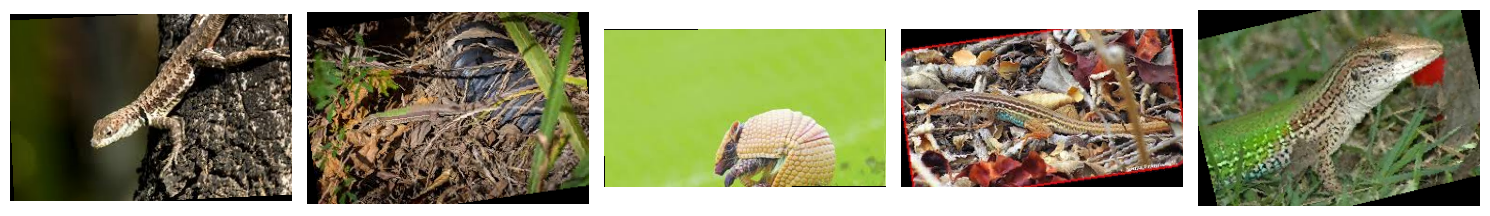

Após RandomAffine


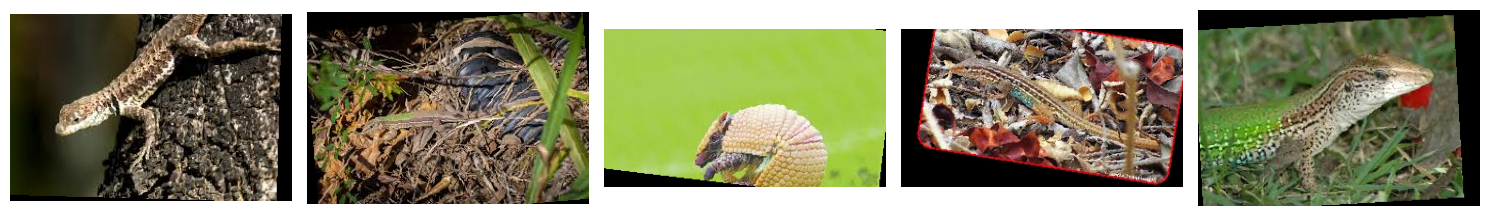

In [6]:
example_dir = os.path.join(data_dir, 'train')
example_set = datasets.ImageFolder(example_dir, transform=None)
example_images = [example_set[i][0] for i in random.sample(range(len(example_set)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de RandomResizedCrop
cropped_images = [transforms.RandomResizedCrop(224)(img) for img in example_images]
print("Após RandomResizedCrop")
show_images(cropped_images)

# Exemplo de RandomHorizontalFlip
flipped_images = [transforms.RandomHorizontalFlip()(img) for img in cropped_images]
print("Após RandomHorizontalFlip")
show_images(flipped_images)

# Exemplo de RandomRotation
rotated_images = [transforms.RandomRotation(15)(img) for img in example_images]
print("Após RandomRotation")
show_images(rotated_images)

# Exemplo de RandomAffine
affined_images = [transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img) for img in example_images]
print("Após RandomAffine")
show_images(affined_images)

In [7]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transform_aug = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 32 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([1, 2])


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


Epoch 1, Train Loss: 0.695, Train Accuracy: 50.00%


/Users/thiago/.pyenv/versions/3.11.10/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.696, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:01<00:00,  7.58it/s]


Epoch 2, Train Loss: 0.693, Train Accuracy: 51.00%
Epoch 2, Val Loss: 0.692, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Epoch 3, Train Loss: 0.694, Train Accuracy: 50.00%
Epoch 3, Val Loss: 0.690, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Epoch 4, Train Loss: 0.693, Train Accuracy: 50.00%
Epoch 4, Val Loss: 0.690, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Epoch 5, Train Loss: 0.692, Train Accuracy: 53.25%
Epoch 5, Val Loss: 0.694, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Epoch 6, Train Loss: 0.692, Train Accuracy: 49.75%
Epoch 6, Val Loss: 0.693, Val Accuracy: 46.72%


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Epoch 7, Train Loss: 0.692, Train Accuracy: 57.25%
Epoch 7, Val Loss: 0.691, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Epoch 8, Train Loss: 0.691, Train Accuracy: 57.25%
Epoch 8, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Epoch 9, Train Loss: 0.690, Train Accuracy: 60.00%
Epoch 9, Val Loss: 0.689, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch 10, Train Loss: 0.690, Train Accuracy: 56.75%
Epoch 10, Val Loss: 0.686, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


Epoch 11, Train Loss: 0.688, Train Accuracy: 63.75%
Epoch 11, Val Loss: 0.685, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Epoch 12, Train Loss: 0.687, Train Accuracy: 63.25%
Epoch 12, Val Loss: 0.681, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:01<00:00,  7.42it/s]


Epoch 13, Train Loss: 0.685, Train Accuracy: 61.50%
Epoch 13, Val Loss: 0.677, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


Epoch 14, Train Loss: 0.681, Train Accuracy: 59.00%
Epoch 14, Val Loss: 0.669, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Epoch 15, Train Loss: 0.677, Train Accuracy: 64.25%
Epoch 15, Val Loss: 0.664, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Epoch 16, Train Loss: 0.669, Train Accuracy: 64.50%
Epoch 16, Val Loss: 0.648, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Epoch 17, Train Loss: 0.664, Train Accuracy: 63.25%
Epoch 17, Val Loss: 0.647, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


Epoch 18, Train Loss: 0.644, Train Accuracy: 64.75%
Epoch 18, Val Loss: 0.621, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


Epoch 19, Train Loss: 0.640, Train Accuracy: 64.50%
Epoch 19, Val Loss: 0.609, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:01<00:00,  8.38it/s]


Epoch 20, Train Loss: 0.602, Train Accuracy: 70.50%
Epoch 20, Val Loss: 0.533, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Epoch 21, Train Loss: 0.534, Train Accuracy: 73.75%
Epoch 21, Val Loss: 0.537, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Epoch 22, Train Loss: 0.528, Train Accuracy: 74.25%
Epoch 22, Val Loss: 0.508, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Epoch 23, Train Loss: 0.470, Train Accuracy: 78.50%
Epoch 23, Val Loss: 0.637, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Epoch 24, Train Loss: 0.497, Train Accuracy: 75.75%
Epoch 24, Val Loss: 0.527, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Epoch 25, Train Loss: 0.464, Train Accuracy: 77.75%
Epoch 25, Val Loss: 0.527, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Epoch 26, Train Loss: 0.394, Train Accuracy: 83.75%
Epoch 26, Val Loss: 0.531, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Epoch 27, Train Loss: 0.353, Train Accuracy: 85.75%
Epoch 27, Val Loss: 0.534, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


Epoch 28, Train Loss: 0.260, Train Accuracy: 88.00%
Epoch 28, Val Loss: 0.634, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


Epoch 29, Train Loss: 0.251, Train Accuracy: 90.25%
Epoch 29, Val Loss: 0.766, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Epoch 30, Train Loss: 0.243, Train Accuracy: 91.00%
Epoch 30, Val Loss: 0.637, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


Epoch 31, Train Loss: 0.145, Train Accuracy: 94.75%
Epoch 31, Val Loss: 0.804, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Epoch 32, Train Loss: 0.198, Train Accuracy: 94.00%
Epoch 32, Val Loss: 0.986, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Epoch 33, Train Loss: 0.210, Train Accuracy: 91.50%
Epoch 33, Val Loss: 0.846, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


Epoch 34, Train Loss: 0.184, Train Accuracy: 91.25%
Epoch 34, Val Loss: 0.883, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:01<00:00,  9.10it/s]


Epoch 35, Train Loss: 0.215, Train Accuracy: 91.50%
Epoch 35, Val Loss: 1.035, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


Epoch 36, Train Loss: 0.139, Train Accuracy: 95.50%
Epoch 36, Val Loss: 1.157, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Epoch 37, Train Loss: 0.162, Train Accuracy: 92.75%
Epoch 37, Val Loss: 0.964, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


Epoch 38, Train Loss: 0.179, Train Accuracy: 93.00%
Epoch 38, Val Loss: 1.102, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  8.94it/s]


Epoch 39, Train Loss: 0.099, Train Accuracy: 96.25%
Epoch 39, Val Loss: 1.038, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


Epoch 40, Train Loss: 0.055, Train Accuracy: 97.75%
Epoch 40, Val Loss: 1.239, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


Epoch 41, Train Loss: 0.018, Train Accuracy: 99.25%
Epoch 41, Val Loss: 1.375, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Epoch 42, Train Loss: 0.011, Train Accuracy: 99.50%
Epoch 42, Val Loss: 1.675, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Epoch 43, Train Loss: 0.003, Train Accuracy: 100.00%
Epoch 43, Val Loss: 2.122, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:01<00:00,  8.03it/s]


Epoch 44, Train Loss: 0.003, Train Accuracy: 100.00%
Epoch 44, Val Loss: 2.034, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:01<00:00,  7.67it/s]


Epoch 45, Train Loss: 0.002, Train Accuracy: 100.00%
Epoch 45, Val Loss: 2.072, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


Epoch 46, Train Loss: 0.001, Train Accuracy: 100.00%
Epoch 46, Val Loss: 2.078, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


Epoch 47, Train Loss: 0.001, Train Accuracy: 100.00%
Epoch 47, Val Loss: 2.215, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch 48, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 48, Val Loss: 2.158, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


Epoch 49, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 49, Val Loss: 2.284, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch 50, Train Loss: 0.000, Train Accuracy: 100.00%
Epoch 50, Val Loss: 2.282, Val Accuracy: 68.03%
Treinamento concluído


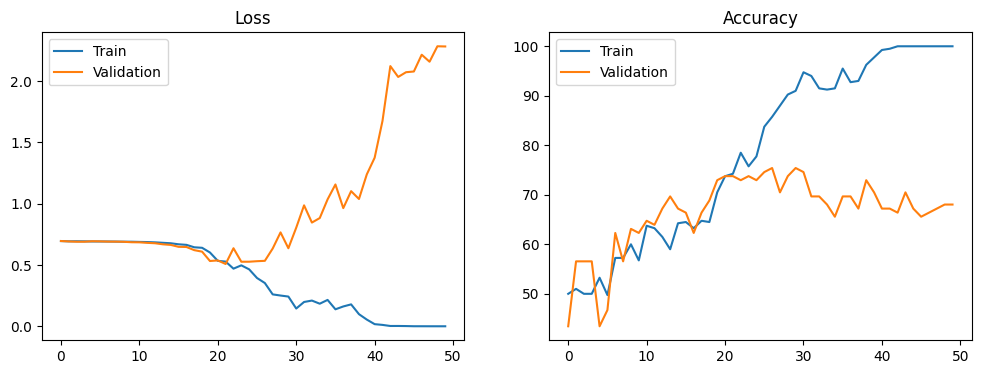

In [9]:
model_no_aug = CNN(num_classes=2).to(device)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.01, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=50)

plot_history(history_no_aug)

100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


Epoch 1, Train Loss: 0.702, Train Accuracy: 50.00%
Epoch 1, Val Loss: 0.685, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.87it/s]


Epoch 2, Train Loss: 0.697, Train Accuracy: 50.00%
Epoch 2, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch 3, Train Loss: 0.693, Train Accuracy: 49.50%
Epoch 3, Val Loss: 0.694, Val Accuracy: 49.18%


100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Epoch 4, Train Loss: 0.693, Train Accuracy: 49.25%
Epoch 4, Val Loss: 0.694, Val Accuracy: 44.26%


100%|██████████| 13/13 [00:01<00:00,  9.10it/s]


Epoch 5, Train Loss: 0.693, Train Accuracy: 45.50%
Epoch 5, Val Loss: 0.692, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Epoch 6, Train Loss: 0.693, Train Accuracy: 51.25%
Epoch 6, Val Loss: 0.694, Val Accuracy: 46.72%


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Epoch 7, Train Loss: 0.693, Train Accuracy: 49.50%
Epoch 7, Val Loss: 0.693, Val Accuracy: 54.10%


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


Epoch 8, Train Loss: 0.693, Train Accuracy: 50.00%
Epoch 8, Val Loss: 0.693, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


Epoch 9, Train Loss: 0.693, Train Accuracy: 50.75%
Epoch 9, Val Loss: 0.690, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


Epoch 10, Train Loss: 0.693, Train Accuracy: 48.00%
Epoch 10, Val Loss: 0.691, Val Accuracy: 58.20%


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


Epoch 11, Train Loss: 0.693, Train Accuracy: 49.25%
Epoch 11, Val Loss: 0.693, Val Accuracy: 52.46%


100%|██████████| 13/13 [00:01<00:00,  9.29it/s]


Epoch 12, Train Loss: 0.692, Train Accuracy: 51.50%
Epoch 12, Val Loss: 0.689, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


Epoch 13, Train Loss: 0.692, Train Accuracy: 52.75%
Epoch 13, Val Loss: 0.690, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Epoch 14, Train Loss: 0.692, Train Accuracy: 56.25%
Epoch 14, Val Loss: 0.690, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


Epoch 15, Train Loss: 0.692, Train Accuracy: 53.25%
Epoch 15, Val Loss: 0.691, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


Epoch 16, Train Loss: 0.691, Train Accuracy: 56.75%
Epoch 16, Val Loss: 0.690, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Epoch 17, Train Loss: 0.691, Train Accuracy: 55.00%
Epoch 17, Val Loss: 0.687, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


Epoch 18, Train Loss: 0.690, Train Accuracy: 57.00%
Epoch 18, Val Loss: 0.687, Val Accuracy: 54.10%


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Epoch 19, Train Loss: 0.690, Train Accuracy: 53.75%
Epoch 19, Val Loss: 0.689, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Epoch 20, Train Loss: 0.690, Train Accuracy: 56.00%
Epoch 20, Val Loss: 0.683, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:01<00:00,  9.64it/s]


Epoch 21, Train Loss: 0.687, Train Accuracy: 58.75%
Epoch 21, Val Loss: 0.683, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


Epoch 22, Train Loss: 0.687, Train Accuracy: 58.50%
Epoch 22, Val Loss: 0.681, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


Epoch 23, Train Loss: 0.684, Train Accuracy: 61.25%
Epoch 23, Val Loss: 0.678, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:01<00:00,  9.29it/s]


Epoch 24, Train Loss: 0.686, Train Accuracy: 55.50%
Epoch 24, Val Loss: 0.672, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


Epoch 25, Train Loss: 0.684, Train Accuracy: 55.50%
Epoch 25, Val Loss: 0.666, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


Epoch 26, Train Loss: 0.681, Train Accuracy: 57.50%
Epoch 26, Val Loss: 0.661, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


Epoch 27, Train Loss: 0.676, Train Accuracy: 58.75%
Epoch 27, Val Loss: 0.669, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Epoch 28, Train Loss: 0.667, Train Accuracy: 58.50%
Epoch 28, Val Loss: 0.647, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Epoch 29, Train Loss: 0.672, Train Accuracy: 56.75%
Epoch 29, Val Loss: 0.646, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:01<00:00,  9.60it/s]


Epoch 30, Train Loss: 0.675, Train Accuracy: 61.00%
Epoch 30, Val Loss: 0.655, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Epoch 31, Train Loss: 0.655, Train Accuracy: 63.50%
Epoch 31, Val Loss: 0.659, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Epoch 32, Train Loss: 0.660, Train Accuracy: 61.75%
Epoch 32, Val Loss: 0.622, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:01<00:00,  9.55it/s]


Epoch 33, Train Loss: 0.638, Train Accuracy: 63.00%
Epoch 33, Val Loss: 0.581, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


Epoch 34, Train Loss: 0.636, Train Accuracy: 64.75%
Epoch 34, Val Loss: 0.565, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


Epoch 35, Train Loss: 0.715, Train Accuracy: 50.25%
Epoch 35, Val Loss: 0.659, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:01<00:00,  9.39it/s]


Epoch 36, Train Loss: 0.658, Train Accuracy: 64.00%
Epoch 36, Val Loss: 0.606, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  9.49it/s]


Epoch 37, Train Loss: 0.636, Train Accuracy: 64.00%
Epoch 37, Val Loss: 0.563, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


Epoch 38, Train Loss: 0.626, Train Accuracy: 64.25%
Epoch 38, Val Loss: 0.543, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


Epoch 39, Train Loss: 0.650, Train Accuracy: 62.00%
Epoch 39, Val Loss: 0.571, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:01<00:00,  9.26it/s]


Epoch 40, Train Loss: 0.638, Train Accuracy: 63.00%
Epoch 40, Val Loss: 0.543, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


Epoch 41, Train Loss: 0.612, Train Accuracy: 63.00%
Epoch 41, Val Loss: 0.568, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:01<00:00,  9.30it/s]


Epoch 42, Train Loss: 0.607, Train Accuracy: 67.00%
Epoch 42, Val Loss: 0.524, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


Epoch 43, Train Loss: 0.653, Train Accuracy: 64.00%
Epoch 43, Val Loss: 0.604, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


Epoch 44, Train Loss: 0.629, Train Accuracy: 65.50%
Epoch 44, Val Loss: 0.602, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


Epoch 45, Train Loss: 0.636, Train Accuracy: 63.50%
Epoch 45, Val Loss: 0.555, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  9.40it/s]


Epoch 46, Train Loss: 0.612, Train Accuracy: 68.75%
Epoch 46, Val Loss: 0.554, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


Epoch 47, Train Loss: 0.635, Train Accuracy: 67.75%
Epoch 47, Val Loss: 0.548, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Epoch 48, Train Loss: 0.628, Train Accuracy: 65.50%
Epoch 48, Val Loss: 0.538, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Epoch 49, Train Loss: 0.608, Train Accuracy: 70.25%
Epoch 49, Val Loss: 0.532, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Epoch 50, Train Loss: 0.643, Train Accuracy: 64.50%
Epoch 50, Val Loss: 0.526, Val Accuracy: 76.23%
Treinamento concluído


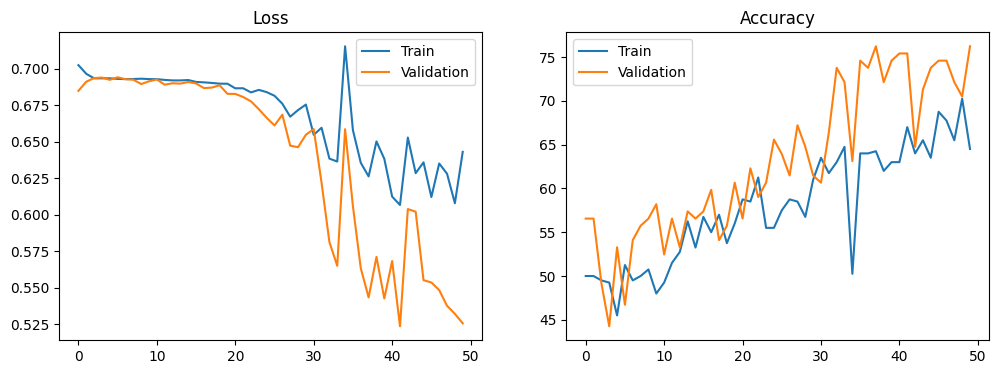

In [10]:
model_aug = CNN(num_classes=2).to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=50)

plot_history(history_aug)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

In [11]:
transform_aug_extended = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Adicionando rotation que faltou na lista original
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug_extended = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_extended)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug_extended = DataLoader(train_set_aug_extended, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


Epoch 1, Train Loss: 0.693, Train Accuracy: 50.00%
Epoch 1, Val Loss: 0.693, Val Accuracy: 45.90%


100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


Epoch 2, Train Loss: 0.693, Train Accuracy: 50.75%
Epoch 2, Val Loss: 0.692, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


Epoch 3, Train Loss: 0.693, Train Accuracy: 49.75%
Epoch 3, Val Loss: 0.688, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


Epoch 4, Train Loss: 0.692, Train Accuracy: 50.00%
Epoch 4, Val Loss: 0.689, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


Epoch 5, Train Loss: 0.694, Train Accuracy: 47.25%
Epoch 5, Val Loss: 0.692, Val Accuracy: 49.18%


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Epoch 6, Train Loss: 0.692, Train Accuracy: 53.50%
Epoch 6, Val Loss: 0.689, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Epoch 7, Train Loss: 0.692, Train Accuracy: 54.25%
Epoch 7, Val Loss: 0.688, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:01<00:00,  6.50it/s]


Epoch 8, Train Loss: 0.692, Train Accuracy: 53.25%
Epoch 8, Val Loss: 0.690, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


Epoch 9, Train Loss: 0.692, Train Accuracy: 53.25%
Epoch 9, Val Loss: 0.687, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


Epoch 10, Train Loss: 0.690, Train Accuracy: 58.25%
Epoch 10, Val Loss: 0.687, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:02<00:00,  6.34it/s]


Epoch 11, Train Loss: 0.690, Train Accuracy: 57.25%
Epoch 11, Val Loss: 0.688, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


Epoch 12, Train Loss: 0.689, Train Accuracy: 56.50%
Epoch 12, Val Loss: 0.685, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 13, Train Loss: 0.689, Train Accuracy: 56.25%
Epoch 13, Val Loss: 0.679, Val Accuracy: 63.93%


100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


Epoch 14, Train Loss: 0.689, Train Accuracy: 55.25%
Epoch 14, Val Loss: 0.680, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


Epoch 15, Train Loss: 0.687, Train Accuracy: 57.75%
Epoch 15, Val Loss: 0.678, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:02<00:00,  6.18it/s]


Epoch 16, Train Loss: 0.682, Train Accuracy: 58.50%
Epoch 16, Val Loss: 0.674, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Epoch 17, Train Loss: 0.688, Train Accuracy: 54.50%
Epoch 17, Val Loss: 0.670, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:02<00:00,  6.08it/s]


Epoch 18, Train Loss: 0.686, Train Accuracy: 54.50%
Epoch 18, Val Loss: 0.669, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Epoch 19, Train Loss: 0.680, Train Accuracy: 57.25%
Epoch 19, Val Loss: 0.658, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Epoch 20, Train Loss: 0.683, Train Accuracy: 58.25%
Epoch 20, Val Loss: 0.660, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Epoch 21, Train Loss: 0.677, Train Accuracy: 58.00%
Epoch 21, Val Loss: 0.642, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Epoch 22, Train Loss: 0.679, Train Accuracy: 58.50%
Epoch 22, Val Loss: 0.636, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


Epoch 23, Train Loss: 0.673, Train Accuracy: 59.00%
Epoch 23, Val Loss: 0.627, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  6.21it/s]


Epoch 24, Train Loss: 0.670, Train Accuracy: 60.75%
Epoch 24, Val Loss: 0.612, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


Epoch 25, Train Loss: 0.669, Train Accuracy: 60.00%
Epoch 25, Val Loss: 0.613, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


Epoch 26, Train Loss: 0.672, Train Accuracy: 58.00%
Epoch 26, Val Loss: 0.608, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Epoch 27, Train Loss: 0.668, Train Accuracy: 60.75%
Epoch 27, Val Loss: 0.600, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:01<00:00,  6.53it/s]


Epoch 28, Train Loss: 0.656, Train Accuracy: 62.75%
Epoch 28, Val Loss: 0.629, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Epoch 29, Train Loss: 0.649, Train Accuracy: 63.50%
Epoch 29, Val Loss: 0.578, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  6.08it/s]


Epoch 30, Train Loss: 0.667, Train Accuracy: 61.50%
Epoch 30, Val Loss: 0.580, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


Epoch 31, Train Loss: 0.646, Train Accuracy: 62.50%
Epoch 31, Val Loss: 0.562, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch 32, Train Loss: 0.679, Train Accuracy: 57.00%
Epoch 32, Val Loss: 0.598, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  6.46it/s]


Epoch 33, Train Loss: 0.660, Train Accuracy: 62.25%
Epoch 33, Val Loss: 0.571, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


Epoch 34, Train Loss: 0.651, Train Accuracy: 61.50%
Epoch 34, Val Loss: 0.596, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  6.15it/s]


Epoch 35, Train Loss: 0.645, Train Accuracy: 63.50%
Epoch 35, Val Loss: 0.576, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


Epoch 36, Train Loss: 0.647, Train Accuracy: 63.25%
Epoch 36, Val Loss: 0.581, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


Epoch 37, Train Loss: 0.668, Train Accuracy: 57.50%
Epoch 37, Val Loss: 0.583, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


Epoch 38, Train Loss: 0.658, Train Accuracy: 60.00%
Epoch 38, Val Loss: 0.575, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch 39, Train Loss: 0.647, Train Accuracy: 65.25%
Epoch 39, Val Loss: 0.552, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Epoch 40, Train Loss: 0.665, Train Accuracy: 60.50%
Epoch 40, Val Loss: 0.566, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Epoch 41, Train Loss: 0.650, Train Accuracy: 63.75%
Epoch 41, Val Loss: 0.607, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:02<00:00,  5.91it/s]


Epoch 42, Train Loss: 0.629, Train Accuracy: 66.00%
Epoch 42, Val Loss: 0.535, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


Epoch 43, Train Loss: 0.662, Train Accuracy: 64.00%
Epoch 43, Val Loss: 0.554, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch 44, Train Loss: 0.647, Train Accuracy: 58.75%
Epoch 44, Val Loss: 0.564, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Epoch 45, Train Loss: 0.636, Train Accuracy: 62.25%
Epoch 45, Val Loss: 0.592, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch 46, Train Loss: 0.685, Train Accuracy: 57.25%
Epoch 46, Val Loss: 0.577, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


Epoch 47, Train Loss: 0.625, Train Accuracy: 64.00%
Epoch 47, Val Loss: 0.561, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Epoch 48, Train Loss: 0.636, Train Accuracy: 62.50%
Epoch 48, Val Loss: 0.571, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch 49, Train Loss: 0.634, Train Accuracy: 63.25%
Epoch 49, Val Loss: 0.553, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


Epoch 50, Train Loss: 0.631, Train Accuracy: 64.00%
Epoch 50, Val Loss: 0.544, Val Accuracy: 71.31%
Treinamento concluído


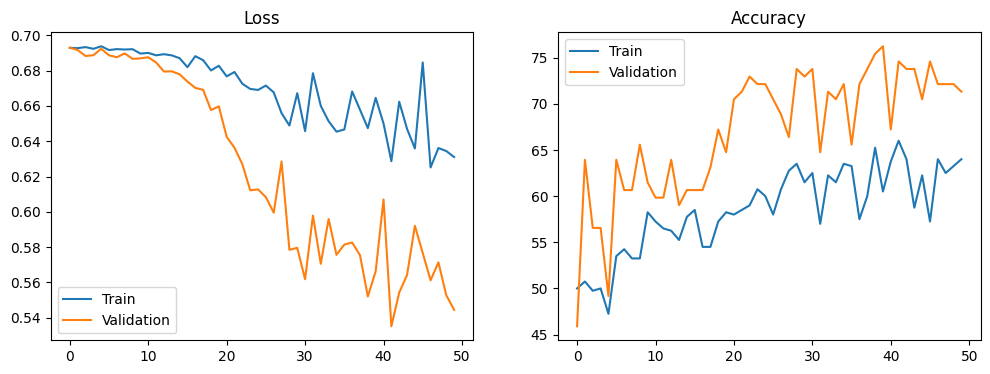

In [12]:
# %%
model_aug_extended = CNN(num_classes=2).to(device)

criterion_aug_extended = nn.CrossEntropyLoss()
optimizer_aug_extended = optim.SGD(model_aug_extended.parameters(), lr=0.01, momentum=0.9)

history_aug_extended = train_model(model_aug_extended, train_loader_aug_extended, val_loader, criterion_aug_extended, optimizer_aug_extended, device, num_epochs=50)

plot_history(history_aug_extended)